In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import requests 
from urllib.parse import urlencode
import statsmodels.stats.api as sms
from  scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
sns.set(
    font_scale = 2,
    style       ="whitegrid",
    rc          ={'figure.figsize':(20, 7)}
)

In [2]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
len(reg_data)

1000000

In [6]:
len(auth_data)

9601013

Проверим дубли и были ли повторные регистрации одного и того же пользователя
Вывод: полных дублей нет, каждый пользователь регистрировался по одному разу

In [7]:
a = [reg_data, auth_data]
for i in a:
    print(i.duplicated().sum())

0
0


In [8]:
# в целом все понятно и на этапе отсутствия дублей, но на всякий случай
reg_data.groupby('uid', as_index = False).reg_ts.nunique().query('reg_ts != 1')

,uid,reg_ts


проверим, были ли регистрации в одно и тоже время вплоть до секунды - если бы были и их было бы много, можно было бы предположить наличие бага и что это на самом деле один и тот же пользователь 
Вывод: подобный баг не обнаружен

In [9]:
reg_data.reg_ts.nunique() == len(reg_data)

True

Сджоиним таблицы (inner). Если строк в новой таблице столько же, сколько в таблице с датами захода в игру - значит left join не нужен

In [10]:
full = reg_data.merge(auth_data, how = 'inner', on = 'uid')
len(full) == len(auth_data)

True

нет ли Null? нет

In [11]:
full.isna().sum()

reg_ts     0
uid        0
auth_ts    0
dtype: int64

Переведем вермя в приемлемый формат

In [12]:
full[['reg_ts', 'auth_ts']] = full[['reg_ts', 'auth_ts']].apply(pd.to_datetime, unit='s')

In [13]:
full.dtypes

reg_ts     datetime64[ns]
uid                 int64
auth_ts    datetime64[ns]
dtype: object

In [14]:
full.head()

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


Посмотрим минимальное и максимальное вермя регистарции и время захода в игру.
Вывод: Регистрация происходит при заходе в игру или во всяком случае момент регистрации = момента первого захода в игру

In [15]:
def min_max(x):
    return(x.min(), x.max())

print('минимальная и максимальная дата и время регистрации:', min_max(full.reg_ts))
print('минимальная и максимальная дата и время захода в игру: ', min_max(full.auth_ts))

минимальная и максимальная дата и время регистрации: (Timestamp('1998-11-18 09:43:43'), Timestamp('2020-09-23 15:17:24'))
минимальная и максимальная дата и время захода в игру:  (Timestamp('1998-11-18 09:43:43'), Timestamp('2020-09-23 15:17:24'))


In [16]:
# теория подтверждена
len(full.query('reg_ts == auth_ts')) == len(reg_data)

True

## Приступаем к заданиям
## Задание 1
### Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

Прежде, чем написать функцию, выполню задание/часть задания без нее. Создадим колонки с датами без времени

In [17]:
full['reg_ts_d'] = full.reg_ts.dt.date
full['auth_ts_d'] = full.auth_ts.dt.date

In [18]:

full_for_cohort = full.groupby(['reg_ts_d', 'auth_ts_d'], as_index=False).agg(uid_nunique=('uid', 'nunique'))
full_for_cohort.head()

,reg_ts_d,auth_ts_d,uid_nunique
0,1998-11-18,1998-11-18,1
1,1999-07-22,1999-07-22,1
2,1999-07-22,1999-07-25,1
3,1999-07-22,1999-07-31,1
4,1999-07-22,1999-08-05,1


In [19]:
full_for_cohort['reg_ts_d'] = pd.to_datetime(full_for_cohort.reg_ts_d, format = '%Y-%m-%d')
full_for_cohort['auth_ts_d'] = pd.to_datetime(full_for_cohort.auth_ts_d, format = '%Y-%m-%d')

Т.к данных очень много, для примера возьмем зарегившихся за последние 10 дней и посмотрим их ретенш. Мы уже знаем, что последняя дата регистрации и, соответственно, входа - 2020-09-23.

In [20]:
for_example_cohort = full_for_cohort.query('reg_ts_d >= "2020-09-13"').copy()
for_example_cohort

,reg_ts_d,auth_ts_d,uid_nunique
2716162,2020-09-13,2020-09-13,1618
2716163,2020-09-13,2020-09-14,32
2716164,2020-09-13,2020-09-15,66
2716165,2020-09-13,2020-09-16,69
2716166,2020-09-13,2020-09-17,83
...,...,...,...
2716223,2020-09-21,2020-09-22,31
2716224,2020-09-21,2020-09-23,49
2716225,2020-09-22,2020-09-22,1641
2716226,2020-09-22,2020-09-23,14


In [21]:
for_example_cohort['lifetime'] = ((for_example_cohort.auth_ts_d - for_example_cohort.reg_ts_d)/np.timedelta64(1, 'D')).round().astype(int)

In [22]:
for_example_cohort

,reg_ts_d,auth_ts_d,uid_nunique,lifetime
2716162,2020-09-13,2020-09-13,1618,0
2716163,2020-09-13,2020-09-14,32,1
2716164,2020-09-13,2020-09-15,66,2
2716165,2020-09-13,2020-09-16,69,3
2716166,2020-09-13,2020-09-17,83,4
...,...,...,...,...
2716223,2020-09-21,2020-09-22,31,1
2716224,2020-09-21,2020-09-23,49,2
2716225,2020-09-22,2020-09-22,1641,0
2716226,2020-09-22,2020-09-23,14,1


In [23]:
cohort_pivot = for_example_cohort.pivot_table(index='reg_ts_d', columns='lifetime', values='uid_nunique')
cohort_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10
reg_ts_d,,,,,,,,,,,
2020-09-13,1618.0,32.0,66.0,69.0,83.0,106.0,105.0,80.0,76.0,80.0,58.0
2020-09-14,1619.0,36.0,62.0,73.0,86.0,105.0,113.0,102.0,72.0,47.0,NaN
2020-09-15,1623.0,36.0,66.0,74.0,98.0,91.0,112.0,92.0,40.0,NaN,NaN
2020-09-16,1625.0,31.0,69.0,75.0,76.0,110.0,113.0,55.0,NaN,NaN,NaN
2020-09-17,1628.0,27.0,70.0,74.0,89.0,102.0,69.0,NaN,NaN,NaN,NaN
2020-09-18,1630.0,31.0,74.0,69.0,85.0,61.0,NaN,NaN,NaN,NaN,NaN
2020-09-19,1634.0,30.0,58.0,77.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-20,1636.0,40.0,71.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-21,1638.0,31.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
cohort_main = cohort_pivot.iloc[:, 0]
matrix = cohort_pivot.divide(cohort_main, axis = 0)
matrix

lifetime,0,1,2,3,4,5,6,7,8,9,10
reg_ts_d,,,,,,,,,,,
2020-09-13,1.0,0.019778,0.040791,0.042645,0.051298,0.065513,0.064895,0.049444,0.046972,0.049444,0.035847
2020-09-14,1.0,0.022236,0.038295,0.045090,0.053119,0.064855,0.069796,0.063002,0.044472,0.029030,NaN
2020-09-15,1.0,0.022181,0.040665,0.045595,0.060382,0.056069,0.069008,0.056685,0.024646,NaN,NaN
2020-09-16,1.0,0.019077,0.042462,0.046154,0.046769,0.067692,0.069538,0.033846,NaN,NaN,NaN
2020-09-17,1.0,0.016585,0.042998,0.045455,0.054668,0.062654,0.042383,NaN,NaN,NaN,NaN
2020-09-18,1.0,0.019018,0.045399,0.042331,0.052147,0.037423,NaN,NaN,NaN,NaN,NaN
2020-09-19,1.0,0.018360,0.035496,0.047124,0.034884,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-20,1.0,0.024450,0.043399,0.023839,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-21,1.0,0.018926,0.029915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
retention_matrix = (matrix
            .style
            .set_caption('Коэффициент удержания клиентов по кагортам')
            .background_gradient(cmap='YlGnBu')
            .highlight_null('white')
            .format("{:.3%}", na_rep=''))

retention_matrix

lifetime,0,1,2,3,4,5,6,7,8,9,10
reg_ts_d,,,,,,,,,,,
2020-09-13 00:00:00,100.000%,1.978%,4.079%,4.265%,5.130%,6.551%,6.489%,4.944%,4.697%,4.944%,3.585%
2020-09-14 00:00:00,100.000%,2.224%,3.830%,4.509%,5.312%,6.485%,6.980%,6.300%,4.447%,2.903%,
2020-09-15 00:00:00,100.000%,2.218%,4.067%,4.559%,6.038%,5.607%,6.901%,5.669%,2.465%,,
2020-09-16 00:00:00,100.000%,1.908%,4.246%,4.615%,4.677%,6.769%,6.954%,3.385%,,,
2020-09-17 00:00:00,100.000%,1.658%,4.300%,4.545%,5.467%,6.265%,4.238%,,,,
2020-09-18 00:00:00,100.000%,1.902%,4.540%,4.233%,5.215%,3.742%,,,,,
2020-09-19 00:00:00,100.000%,1.836%,3.550%,4.712%,3.488%,,,,,,
2020-09-20 00:00:00,100.000%,2.445%,4.340%,2.384%,,,,,,,
2020-09-21 00:00:00,100.000%,1.893%,2.991%,,,,,,,,


## Приступаем к написанию функции. Очевидно, что нам нужно либо самостоятельно ограничить данные из таблицы какими-то днями, либо предоставить возможность выбирать период. Последнее - удобнее.

In [26]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [27]:
def cohort(reg_data, auth_data):
    
    # input
    
    min_date_cahort = input('Введите начальную дату для анализа ретеншена в формате ГГГГ-ММ-ДД ')
    max_date_cahort = input('Введите финальную дату для анализа ретеншена в формате ГГГГ-ММ-ДД ')
    min_date_cahort = pd.to_datetime(min_date_cahort, format = '%Y-%m-%d')
    max_date_cahort = pd.to_datetime(max_date_cahort, format = '%Y-%m-%d')
    color_of_table  = input('Введите цветовую палитру, в которой будет оформлен ответ. Например, YlGnBu: ')
    color_of_nan    = input('Введите цветовую палитру, в которой будут оформлены NULL. Например, white: ')
    
    
    # создаем колонки только с датами, без времени
    
    reg_data['reg_d']   = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
    auth_data['auth_d'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date
    
    # объединим таблицы
    
    full = reg_data.merge(auth_data, how = 'inner', on='uid')
    
    # теперь отбросим все лишнее из full
    
    full_split = full.query('reg_d >= @min_date_cahort and reg_d <= @max_date_cahort')
    
    # посчитаем, сколько было заходов уникальных пользователей
    
    full_for_cohort = full_split.groupby(['reg_d', 'auth_d'], as_index=False).agg(uid_nunique=('uid', 'nunique')).copy()
    
    # еще раз на всякий случай переводим столбцы в формат дат
    
    full_for_cohort['reg_d'] = pd.to_datetime(full_for_cohort.reg_d, format = '%Y-%m-%d')
    full_for_cohort['auth_d'] = pd.to_datetime(full_for_cohort.auth_d, format = '%Y-%m-%d')
    
    # Считаем разницу в днях между датой захода и датой регистрации
    
    full_for_cohort['lifetime'] = ((full_for_cohort.auth_d - full_for_cohort.reg_d)/np.timedelta64(1, 'D')).round().astype(int)
    
    # переведем reg_d в object, что бы индекс был без времени (00:00:00)
    
    full_for_cohort.reg_d = full_for_cohort.reg_d.astype('str')
    
    # создаем сводную таблицу
    
    cohort_pivot = full_for_cohort.pivot_table(index='reg_d', columns='lifetime', values='uid_nunique')
    
    # т.к в момент регистрации игрок еще и первый раз входит в игру, логично, что при lifetime 0 - 100% посещения.
    
    cohort_main = cohort_pivot.iloc[:, 0]
    matrix = cohort_pivot.divide(cohort_main, axis = 0)
    
    # Красиво оформляем
    
    retention_matrix = (matrix
            .style
            .set_caption('Коэффициент удержания клиентов по кагортам')
            .background_gradient(cmap= color_of_table)
            .highlight_null(color_of_nan)
            .format("{:.3%}", na_rep=''))
    
    return retention_matrix
    
    

In [29]:
cohort(reg_data, auth_data)

Введите начальную дату для анализа ретеншена в формате ГГГГ-ММ-ДД 2020-09-13
Введите финальную дату для анализа ретеншена в формате ГГГГ-ММ-ДД 2020-09-23
Введите цветовую палитру, в которой будет оформлен ответ. Например, YlGnBu: YlGnBu
Введите цветовую палитру, в которой будут оформлены NULL. Например, white: green


lifetime,0,1,2,3,4,5,6,7,8,9,10
reg_d,,,,,,,,,,,
2020-09-13,100.000%,1.978%,4.079%,4.265%,5.130%,6.551%,6.489%,4.944%,4.697%,4.944%,3.585%
2020-09-14,100.000%,2.224%,3.830%,4.509%,5.312%,6.485%,6.980%,6.300%,4.447%,2.903%,
2020-09-15,100.000%,2.218%,4.067%,4.559%,6.038%,5.607%,6.901%,5.669%,2.465%,,
2020-09-16,100.000%,1.908%,4.246%,4.615%,4.677%,6.769%,6.954%,3.385%,,,
2020-09-17,100.000%,1.658%,4.300%,4.545%,5.467%,6.265%,4.238%,,,,
2020-09-18,100.000%,1.902%,4.540%,4.233%,5.215%,3.742%,,,,,
2020-09-19,100.000%,1.836%,3.550%,4.712%,3.488%,,,,,,
2020-09-20,100.000%,2.445%,4.340%,2.384%,,,,,,,
2020-09-21,100.000%,1.893%,2.991%,,,,,,,,


# Первое задание выполнено

## Второе задание:
## Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

## Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [30]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' # импортируем напрямую с яндекс-диска
public_key_1 = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 
final_url_1 = base_url + urlencode(dict(public_key=public_key_1)) 
response_1 = requests.get(final_url_1)
download_url_1 = response_1.json()['href'] 
df = pd.read_csv(download_url_1, sep=';')

In [31]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Сравним количество уникальных юзеров с количеством строк.  
Вывод: в каждой строчке уникальный юзер. Это также говорит о том, что если юзер совершал две и более покупки - они суммируются

In [32]:
df.user_id.nunique() == len(df)

True

In [33]:
df.isna().sum() # NULL нет, дублей быть не может, т.к user_id уникален

user_id      0
revenue      0
testgroup    0
dtype: int64

In [34]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

Посчитаем количество строк в каждой группе, сумму денег, потраченной группой и средняя сумма на пользователя

In [35]:
df.query('testgroup == "a"').revenue.agg(['count', 'sum', 'mean'])

count    2.021030e+05
sum      5.136189e+06
mean     2.541372e+01
Name: revenue, dtype: float64

In [36]:
df.query('testgroup == "b"').revenue.agg(['count', 'sum', 'mean'])

count    2.026670e+05
sum      5.421603e+06
mean     2.675129e+01
Name: revenue, dtype: float64

In [37]:
df.revenue.min() # отрицательных (т.е возвратов) нет, но и быть не могло, т.к у нас каждый пользователь уникален

0

Узнаем, какая группа является контрольной/тестовой

In [38]:
len(df.query('testgroup == "a" and revenue > 0')) # - группа А - контрольная.

1928

Узнаем, действительно ли ARPU отличается на 5%

In [39]:
100 - df.query('testgroup == "a"')['revenue'].mean() * 100  / df.query('testgroup == "b"')['revenue'].mean() # действительно

5.000009444962146

Краткий вывод из быстрого просмотра:  
1) Группа а - контрольная, b - тестовая   
2) в df нет данных о количестве совершенных покупок, лишь о сумме покупок за исследуемый период  
3) Arpu действительно отличается на 5 %, заявленное количество купишвших в каждой группе подтверждается  

посмотрим на гистограммы без разбивки на группы, с разбивкой, а также тоже самое только по тем, кто совершил покупку

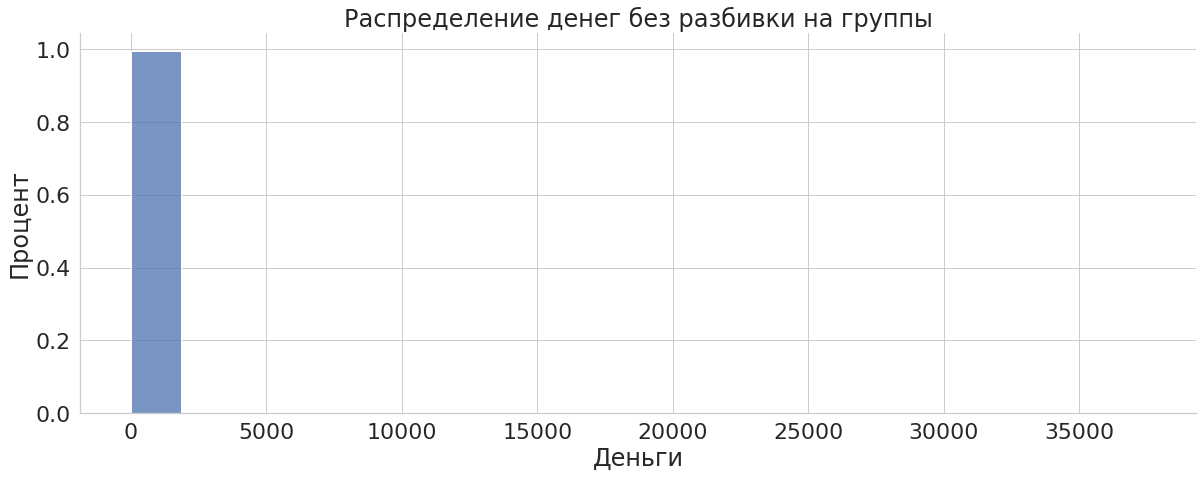

In [40]:
ax = sns.histplot(df['revenue'], stat = 'probability')
ax.set_xlabel('Деньги')
ax.set_ylabel('Процент')
ax.set_title('Распределение денег без разбивки на группы')
sns.despine()

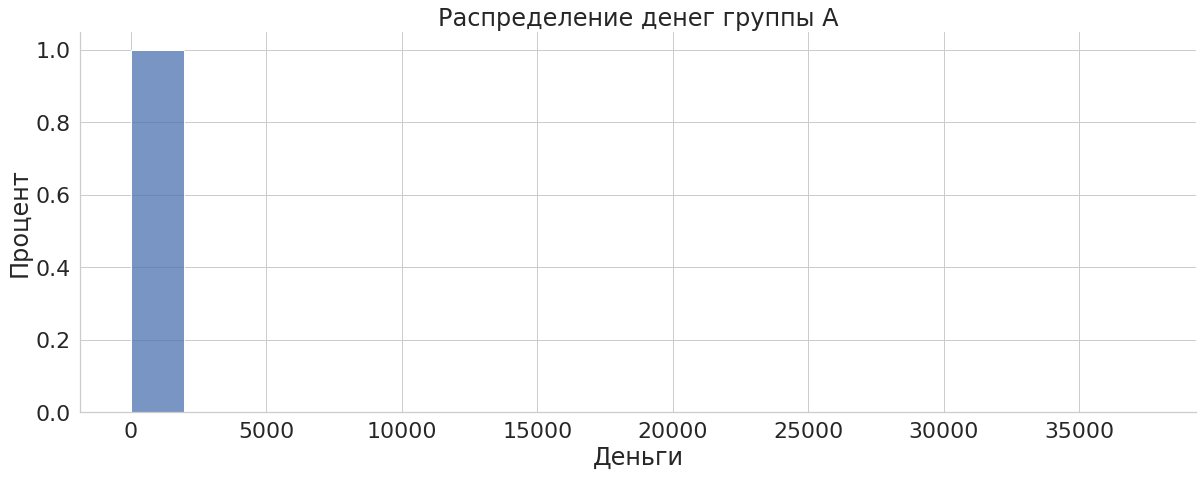

In [41]:
ax1 = sns.histplot(df.query('testgroup == "a"')['revenue'], stat = 'probability')
ax1.set_xlabel('Деньги')
ax1.set_ylabel('Процент')
ax1.set_title('Распределение денег группы А')
sns.despine()

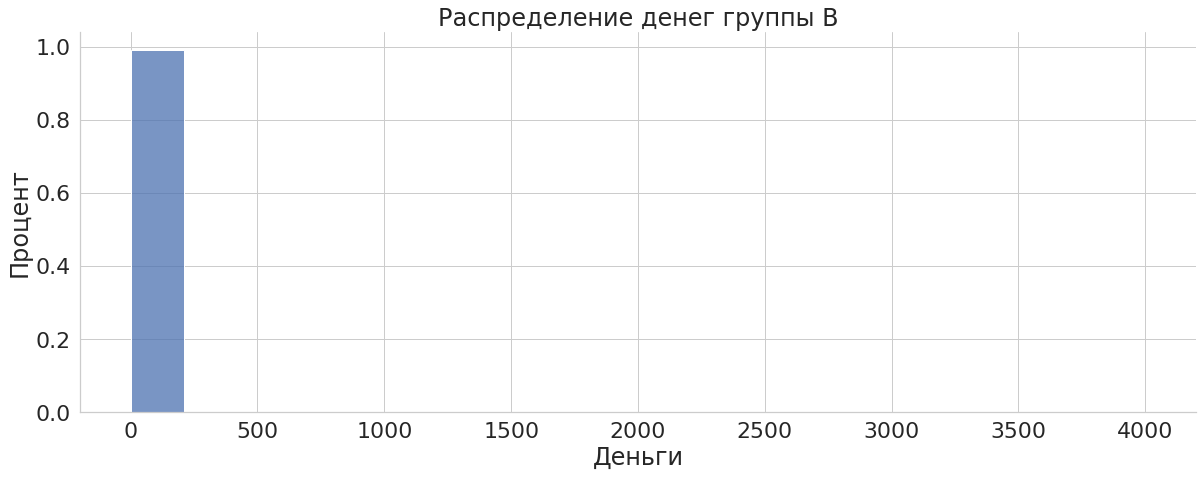

In [42]:
ax2= sns.histplot(df.query('testgroup == "b"')['revenue'], stat = 'probability')
ax2.set_xlabel('Деньги')
ax2.set_ylabel('Процент')
ax2.set_title('Распределение денег группы B')
sns.despine()

Видим, что у группы А в распределении денег очень длинный хвост, тогда как у b - гораздо короче

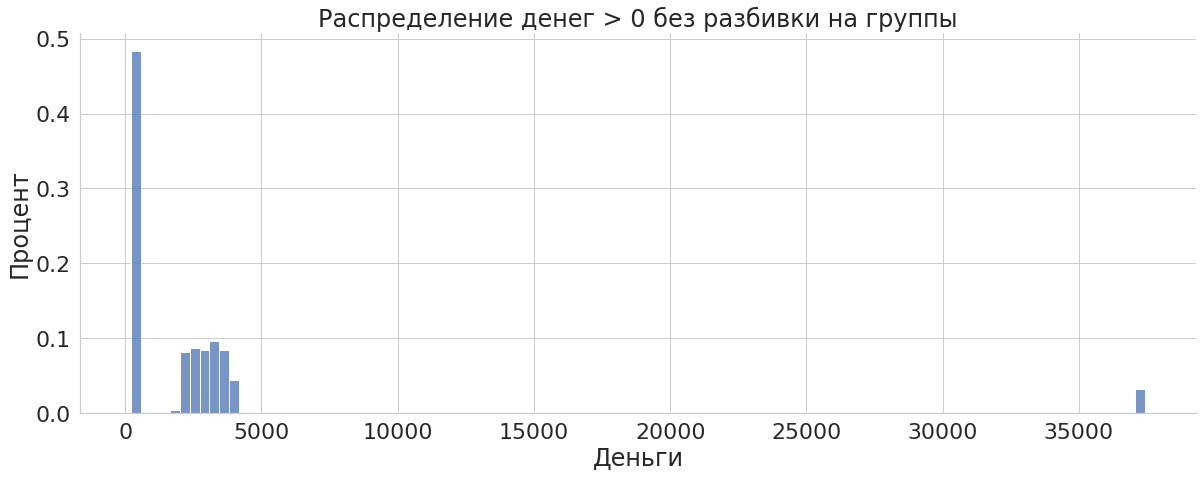

In [43]:
ax = sns.histplot(df.query('revenue > 0')['revenue'], stat = 'probability')
ax.set_xlabel('Деньги')
ax.set_ylabel('Процент')
ax.set_title('Распределение денег > 0 без разбивки на группы')
sns.despine()

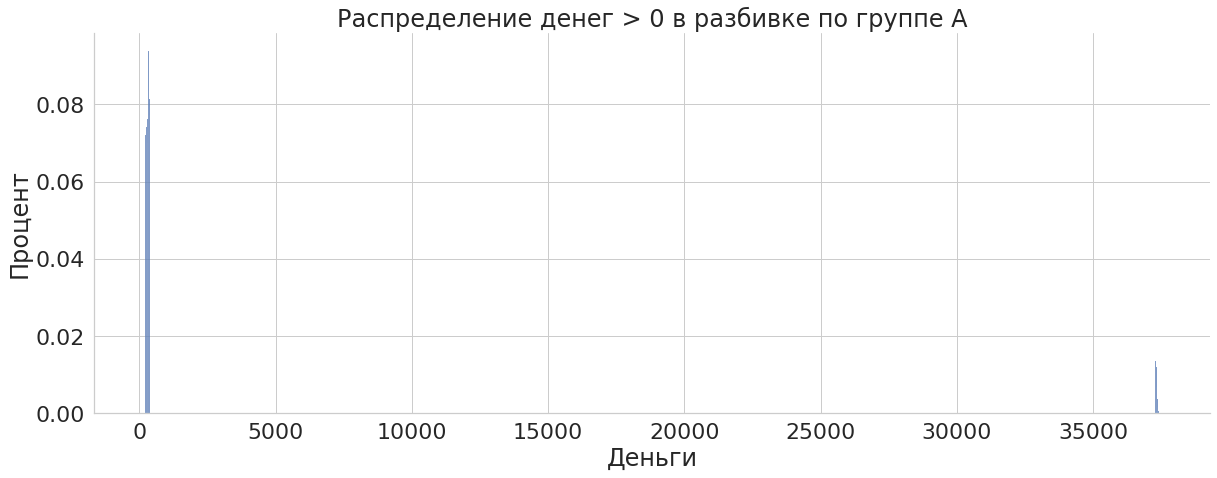

In [44]:
ax = sns.histplot(df.query('revenue > 0 and testgroup == "a"')['revenue'], stat = 'probability')
ax.set_xlabel('Деньги')
ax.set_ylabel('Процент')
ax.set_title('Распределение денег > 0 в разбивке по группе А')
sns.despine()

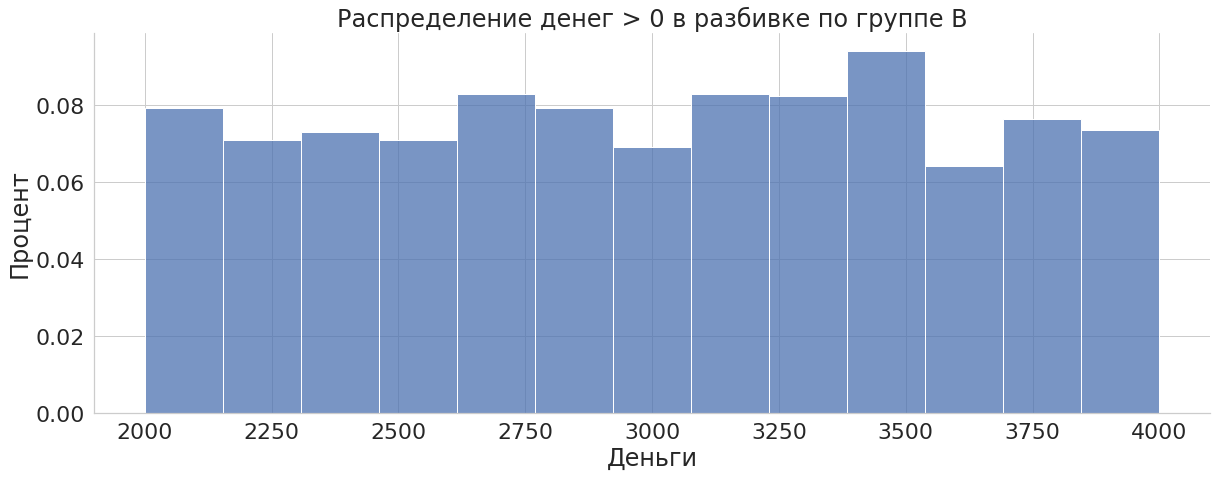

In [45]:
# похоже на равномерное распределение
ax = sns.histplot(df.query('revenue > 0 and testgroup == "b"')['revenue'], stat = 'probability')
ax.set_xlabel('Деньги')
ax.set_ylabel('Процент')
ax.set_title('Распределение денег > 0 в разбивке по группе B')
sns.despine()

Также построим боксплоты (с фильтром revenue > 0)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


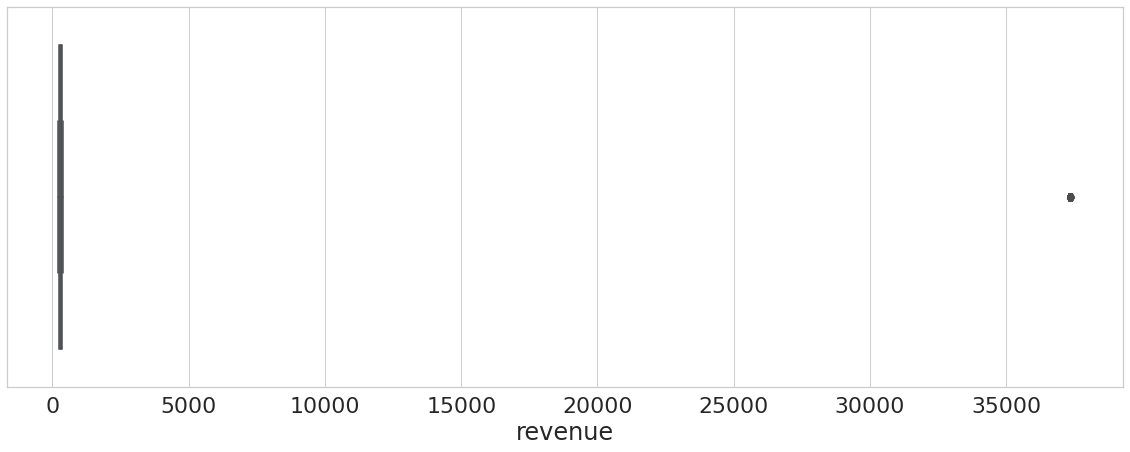

In [46]:
sns.boxplot(df.query('revenue > 0 and testgroup == "a"')['revenue'])

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


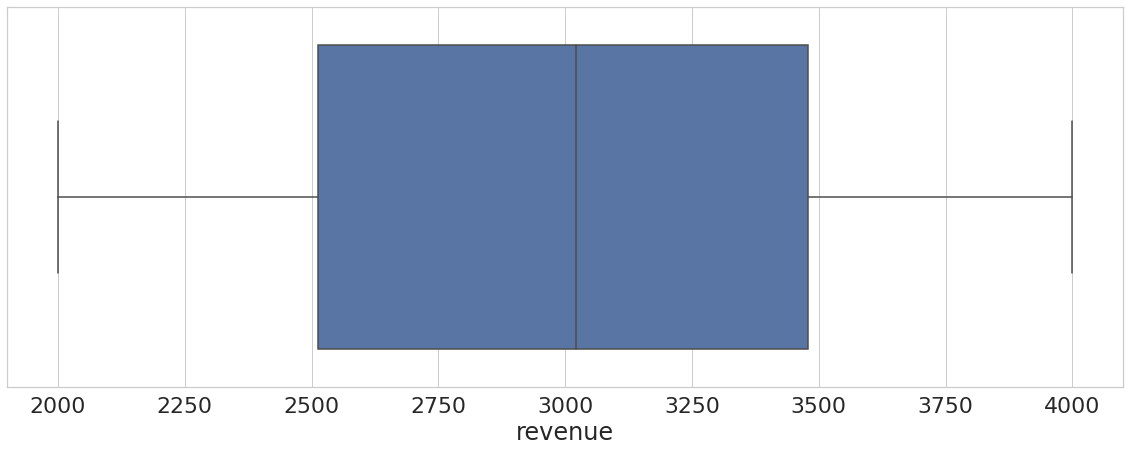

In [47]:
sns.boxplot(df.query('revenue > 0 and testgroup == "b"')['revenue'])

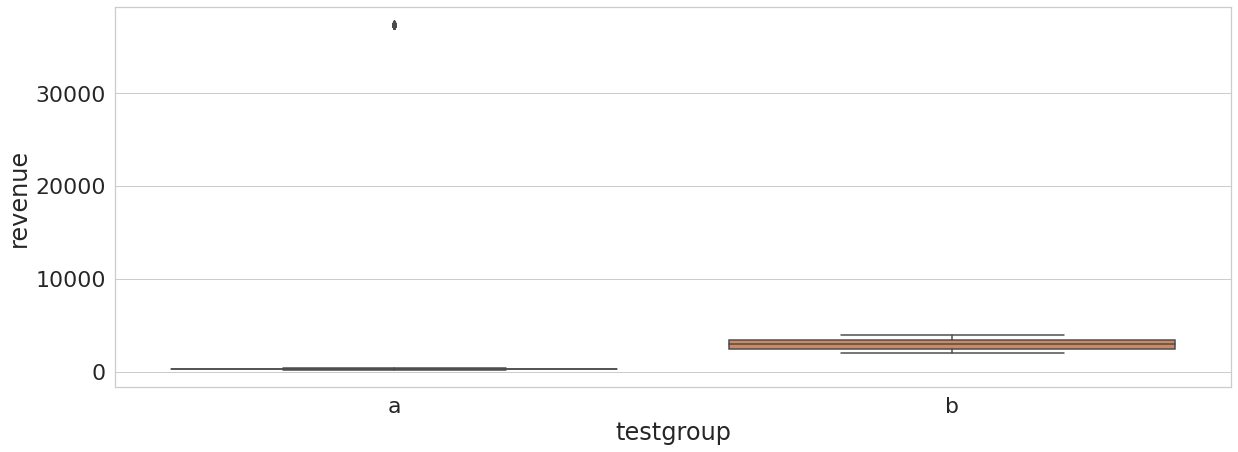

In [48]:
 sns.boxplot(x="testgroup", y="revenue", data=df.query('revenue > 0'))

По графикам видим, что в группе А огромный выброс. Проверим и подумаем, что с этим можно сделать

In [49]:
df.query('testgroup == "a" and revenue > 5000')[['revenue']].sort_values('revenue', ascending = False).shape[0]

123

### Вывод: я предполагал, что у нас всего один выброс, но их 123 и это уже нельзя объяснить простым совпадением. Я не стану исключать строки с revenue > 37к при расчете метрик

### В качестве рассматриваемых метрик выберем ARPU и ARPPU. Но для начала также рассмотрим возможность провести A/B тест на  CR
### Мы не можем просто посчитать, например, что нам выгоднее, больше CR, но меньше ARPU при таком соотношении или меньше CR, но больше ARPU, поскольку данные результаты могли быть случайными. Для начала подтвердим, что различия в ряде метрик между группами стат. значимы.

начнем с CR. По-хорошему, до проведения эксперимента нужно определить, какую минимальную разницу мы хотим зафиксировать, с какой мощностью (power), каким уровнем значимости и расчитать, какая должна быть выборка. Но далее мы сами определелим данные критерии, а сейчас посчитаем получившийся CR

In [50]:
# CR в группах
print('конверсия в группе А: ',len(df.query('testgroup == "a" and revenue != 0'))/len(df.query('testgroup == "a"')))
print('конверсия в группе В: ',len(df.query('testgroup == "b" and revenue != 0'))/len(df.query('testgroup == "b"')))
print('разница в конверсиях с преимуществом группы А :', len(df.query('testgroup == "a" and revenue != 0'))/len(df.query('testgroup == "a"')) - len(df.query('testgroup == "b" and revenue != 0'))/len(df.query('testgroup == "b"')))

конверсия в группе А:  0.009539690157988749
конверсия в группе В:  0.008906235351586593
разница в конверсиях с преимуществом группы А : 0.0006334548064021554


Посчитаем, какая нам нужна минимальная выборка при power = 80%, alpha = 5% при меющихся CR
Вывод: что бы задетектить такие незначительные изменения, нужна слишком большая выборка (минимум по 357871 человек в каждой группе - у нас данные по 202 тысячи

In [51]:
es = sms.proportion_effectsize(0.009539, 0.008906)
sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1)

357871.2747378369

Подберем результат, который нас устраивает при заданных параметрах и выборке:  
Вывод: Примерно такой уровень значимости нужен (20.59%) , что бы при заданной мощности при таких результатах CR в двух группах и при такой выборке обнарушить стат. значимые изменения. Считаю, что сравнение  CR в данном случае смысла не имеет

In [52]:
es = sms.proportion_effectsize(0.009539, 0.008906)
sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.2059, ratio=1)

202072.40168308618

Проведем тест хи-квадрат пирсона, но опираться на CR все равно не будем из-за ранее изложенных причин

In [53]:
for_CR = np.array([[len(df.query('testgroup == "a" and revenue != 0')),\
                   len(df.query('testgroup == "a"')) - len(df.query('testgroup == "a" and revenue != 0'))],\
                   [len(df.query('testgroup == "b" and revenue != 0')),\
                   len(df.query('testgroup == "b"')) - len(df.query('testgroup == "b" and revenue != 0'))]]) 

CR_chi2_contingency = chi2_contingency(for_CR)
print('chisq-statistic=%.4f, p-value=%.5f, df=%i expected=%s'%CR_chi2_contingency)

chisq-statistic=4.3747, p-value=0.03648, df=1 expected=[[  1863.89924896 200239.10075104]
 [  1869.10075104 200797.89924896]]


### Проверять двумя тестами одну и ту же метрику нельзя, но раз мы все равно решили, что размера выборки у нас не достаточно для корректного эксперимента по CR,  покажу еще один тест для обнаружения стат. значимых имзенений CR

In [54]:
proportions_ztest([len(df.query('testgroup == "a" and revenue != 0')), 
                   len(df.query('testgroup == "b" and revenue != 0'))], 
                  [len(df.query('testgroup == "a"')), 
                   len(df.query('testgroup == "b"'))], 
                  alternative = 'two-sided')[1]

0.035028524642854865

### Вывод по CR: данный A/B тест лучше не проводить, т.к выборка слишком мала для того, что бы с приемлемой мощностью и уровнем значимости проверять обнаружить разницу в (возьмем получившийся пример) 0.06% - это очень маленькая разница, которую возможно обнаружить только при еще бОльшей выборке

Для ARPU проведем T-test. В данном случае выборка и различие в средних достаточны, что бы мы могли применить данный тест, несмотря на то, что явно распределение ненормально. H0 - средние двух групп стат. значимо не отличаются. H1 - средние двух групп стат. значимо отличаются. Уровень значимости (alpha) - 5% (0.05).

In [55]:
stats.shapiro(df[df['testgroup'] == 'a']['revenue'].sample(200000, random_state=17))
 
                                         # распределение не нормально, т.к H0- распределение нормально, а мы принимаем H1 
                                         # при n > 5000 рекомендовано делать сэмплы

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.008891761302947998, pvalue=0.0)

In [56]:
stats.shapiro(df[df['testgroup'] == 'b']['revenue'].sample(200000, random_state=17)) 
# распределение не нормально, т.к H0- распределение нормально, а мы принимаем H1

ShapiroResult(statistic=0.06587332487106323, pvalue=0.0)

Проведем T-test для определения стат. значимости различий ARPU

In [57]:
stats.ttest_ind(df.query('testgroup == "a"').revenue, df.query('testgroup == "b"').revenue, alternative = 'two-sided')

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

### Вывод по ARPU - средние стат. значимо не отличаются (принимаем H0), т.к вероятность получение таких  различий при верности H0 = 53%, что больше 5%, ниже которых мы бы уже отвергали H0

Теперь проведем A/B тест с ARPPU. H0 - средние двух групп (только среди совершивших покупку) стат. значимо не отличаются. H1 - средние двух групп (только среди совершивших покупку) стат. значимо отличаются. Уровень значимости (alpha) - 5% (0.05)

In [58]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2500, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

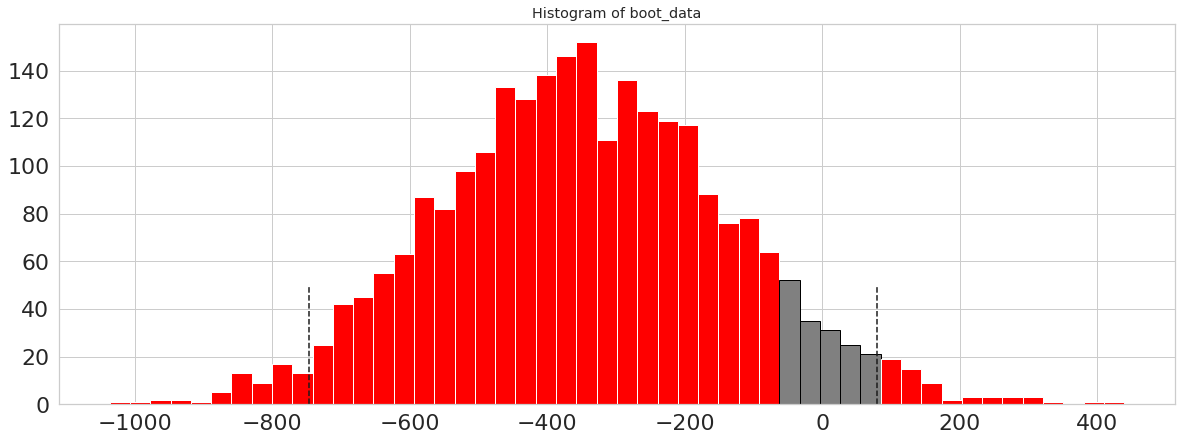

0.10108866205467988

In [59]:
ARPPU_mean = get_bootstrap(df.query('testgroup == "a" and revenue > 0')['revenue'], 
                           df.query('testgroup == "b" and revenue > 0')['revenue'])
ARPPU_mean['p_value']

### Принимаем H0 - ARPPU стат. значимо не отличается. Вероятность получения таких различий при верности H0 составляет 10% - не можем отвергнуть H0

Поскольку по основным метрикам сделать вывод не получается (не смогли доказатьс стат. значимое изменение ARPU, ARPPU, а для CR и наблюдаемой разницы слишком маленькая выборка), посмотрим на различия в данных

In [60]:
df_a = df.query('testgroup == "a" and revenue > 0').copy()
df_b = df.query('testgroup == "b" and revenue > 0').copy()

In [61]:
df_a.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [62]:
df_b.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

In [63]:
df_a.query('revenue > 30000').revenue.min()

37293

qcut(и с duplicates = 'drop') и cut по умолчанию в данном случае работают некорректно. Я самостоятельно присвою разбивку

In [64]:
df_a['revenue_bins'] = pd.cut(df.revenue, [200, 257, 311, 361, 400, 37292, 37433])
df_b['revenue_bins'] = pd.cut(df.revenue, [2000, 2513, 3022, 3478, 4000])

In [65]:
df_a.revenue_bins.value_counts()

(311, 361]        481
(257, 311]        480
(200, 257]        478
(361, 400]        358
(37292, 37433]    123
(400, 37292]        0
Name: revenue_bins, dtype: int64

In [66]:
df_b.revenue_bins.value_counts()

(2000, 2513]    453
(3478, 4000]    451
(3022, 3478]    451
(2513, 3022]    449
Name: revenue_bins, dtype: int64

### Несмотря на то, что CR показал стат. значимые различия, результатам данного теста доверять не следует, поскольку, что бы обнаружить столь малые отличия в CR понадобилась бы бОльшая выборка. При этом ARPU и ARPPU не показали стат. значимых различий при уровне значимости 0.05

### Однако, если исключить A/B тесты, мы заметили, что в группе А пользователи чаще делают покупки на 200-400 у.е., но при этом есть целых 123 человка (из 1928), которые купили на аномально большие суммы - от 37292 у.е. до 37433 у.е. В тестовой группе все более стабильно. Медиана более чем в 10 раз больше чем медиана контрольной группы, значения варьируются от 2000 до 4000 тысяч и сами группы, на которые мы разделили значения (используя процентили) примерно равны.

### Вывод: учитывая, что стат. значимое изменение ARPU и ARPPU не зафиксировано, а тест по CR невозможен с текущей выборкой,  буду исходить из того, что в ключевых показателях разница не доказана. Остается определить, что важнее:   акционная система (контрольная), при которой большинство пользователей будут платить сравнительно мало, но при этом будет небольшой процент тех, кто огромными покупками окупит всю акционную систему, либо акционная система (тестовая), при которой у нас не предвидится аномально больших покупок одним пользователем, но при этом каждый тратит сильно больше нижних и даже верхних значений (если не брать траты > 37к) контрольной группы.

### У нас недостаточно данных, что бы объективно выбрать одну из акционных систем, нужно смотреть на длительность акции, жизненный цикл продукта и пр. Однако, именно на уровне интуиции мне больше импонируют результаты в тестовой группе, т.к невольно возникает аналогия с экономической системой, где большой средний класс и небольшое экономическое расслоение и система, где подавляющее большинство бедные, но есть сверхбогатые, без среднего класса. Первая экономическая система обычно более устойчивая и имеет больше перспектив.

### При выполнении задания я исходил из репрезентативости выборки.

## Задание 3
## А) В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

## Б) Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

А)  
1) DAU/WAU - количество уникальных пользователей, зашедших в приложение за сутки/неделю. Учитывая, что прохождение события дает бонусы, рассчитываем на увеличение данного показателя  
2) CR_1 - отношение тех (уникальных пользователей), кто зашел в событие к тем, кто зашел в приложение. Так мы увидим заинтересованность пользователей к событию. Важно оценить, насколько пользователю интересно само событие.     
3) СR_2 - отношение тех (уникальных пользователей), кто не прошел ни один уровень/прошел "N" уровень/ прошел все к тем, кто участвовал в событии. Важно оценить, на каком этапе пользователи перестают проходить события: вдруг уровень слишком сложен или бонусы в конце не интересны. Если уровни слишком сложные и время сильно ограничено, можно предложить за деньги дать дополнительное время.  
4) CR_3 - отношение тех (уникальных пользователей), которые зашли в  течение недели в приложение после события ко всем уникальным пользователям. Данную метрику можно сравнить с тем, что было за неделю до события, возможно провести A/B тест, что бы посмотреть, как событие влияет на посещение приложения после события.  
5) Сколько раз в среднем за время проведения события заходят пользователи, после завершения всех уровней, но в период действия события. Тут нам интересно посмотреть, интересовало ли пользователей только не пропустить бонусы, или им в целом интересна игра сама по себе.  
6) За сколько сессий в среднем пользователь завершает событие (из завершивших событие пользователей). Здесь нам интересно количество сессий, которое в среднем нужно пользователям для завершения событий - так мы сможем оценить вовлеченность игроков в событие и сколько времени они могли бы при желании тратить на игру вне события.  
7) ASD - cреднее время сессии за период. Здесь нам интересно посмотреть не только среднее время сессии в собитии, но и среднее время сессии в период события, как в самом событии, так и в целом в приложении.  
8) Retention rate - отношение вернувшихся в приложение пользователей к числу установивших его в определенную дату. Можно проверить, как событие влияет на retention rate.  
9) Churn rate - отток клиентов. Можно рассчитывать по-разному. Думаю, интереснее рассматривать данную метрику будет после завершения события.  
10) ARPU/ARPPU/ATV  (за период проведения события) поскольку мы проводим событие, то оно так или иначе должно стимулировать либо мгновенный рост прибыли, либо увеличение других метрик за счет события и как итог - увеличение прибыли в последствие. Если данное событие дает игроку бонусы, которые он мог приобрести за деньги, то скорее всего одномоментно в деньгах компания потеряет (особенно если нет возможности платно продлевать возможнео время прохождения события или уровни легко пройти за указанное время и продление времени - не популярная позиция), но при этом за счет удержания пользователей в ближайшей перспективе прибыль должна увеличиться и покрыть "издержки" события.  

Важно смотреть на изменение метрик не только во время события, но и до и после события.  

Б) Я считаю, что набор метрик менять не нужно, но при этом не вижу смысл вводить указанное изменение. Оно лишь будет раздражать игроков, если при этом не будут повторены бонусы за уровень. А если будут - это стимул специально "заваливать" уровни для отката на уровень ниже и  бОльшей выгоды за счет повтора бонусов с уже пройденного ранее уровня. При этом, если бонусы не будут повторяться, то можно предложить попытку без отката за небольшую сумму, т.к  мы все равно готовы дать игроку указанные бонусы, почему бы на этом немного не заработать?  
Особое внимание при введении данного изменения я бы обратил на retention rate, churn rate, на метрики из п. 2,3,4, т.к данная мера, как я ранее заявлял, на мой взгляд является лишь раздражителем , т.к проходить одни и те же уровни скучно (тем более без новых бонусов). Если вводить данную меру, то с возможностью за небольшую плату не откатываться на прошлые уровни.

